In [17]:
import os
import numpy as np 
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [18]:
def get_pixel_values(image_path):
    img = Image.open(image_path).convert('L').resize((48, 48))
    return list(img.getdata())

# Dynamically get emotion classes from emotion_data directory
emotion_data_dir = '/kaggle/input/emotion-data/emotion_data'  # Updated path
emotionList = [d for d in os.listdir(emotion_data_dir) if os.path.isdir(os.path.join(emotion_data_dir, d))]
emotionList.sort()  # Ensure consistent order
DigitAssigned = {emotion: idx for idx, emotion in enumerate(emotionList)}

no_of_images = 0
for emotion in emotionList:
    no_of_images += len(os.listdir(os.path.join(emotion_data_dir, emotion)))
no_of_images    

10382

In [19]:
def Emotion_Model(input_shape=(48, 48, 1)):
    # Input layer
    inputImg = tf.keras.layers.Input(shape=input_shape, name='input')
    
    # Convert grayscale to RGB by repeating the channel 3 times
    x = tf.keras.layers.Concatenate(axis=-1)([inputImg, inputImg, inputImg])
    
    # Initialize pre-trained models
    resnet_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    vgg_base = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
    
    # Freeze the pre-trained layers
    for layer in resnet_base.layers:
        layer.trainable = False
    for layer in vgg_base.layers:
        layer.trainable = False
    
    # Get features from ResNet50
    resnet_features = resnet_base(x)
    resnet_features = tf.keras.layers.GlobalAveragePooling2D()(resnet_features)
    resnet_features = tf.keras.layers.Dense(512, activation='relu')(resnet_features)
    resnet_features = tf.keras.layers.Dropout(0.3)(resnet_features)
    
    # Get features from VGG16
    vgg_features = vgg_base(x)
    vgg_features = tf.keras.layers.GlobalAveragePooling2D()(vgg_features)
    vgg_features = tf.keras.layers.Dense(512, activation='relu')(vgg_features)
    vgg_features = tf.keras.layers.Dropout(0.3)(vgg_features)
    
    # Custom CNN path
    conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(inputImg)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = tf.keras.layers.Dropout(0.3)(pool1)
    
    conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(drop1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, kernel_size=3, activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = tf.keras.layers.Dropout(0.3)(pool2)
    
    conv3 = tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu', padding='same')(drop2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = tf.keras.layers.Dropout(0.3)(pool3)
    
    # Flatten and get features from custom CNN
    custom_features = tf.keras.layers.Flatten()(drop3)
    custom_features = tf.keras.layers.Dense(512, activation='relu')(custom_features)
    custom_features = tf.keras.layers.Dropout(0.3)(custom_features)
    
    # Combine all features
    combined_features = tf.keras.layers.concatenate([resnet_features, vgg_features, custom_features])
    
    # Dense layers for final classification
    dense1 = tf.keras.layers.Dense(1024, activation='relu')(combined_features)
    dense1 = tf.keras.layers.BatchNormalization()(dense1)
    dense1 = tf.keras.layers.Dropout(0.4)(dense1)
    
    dense2 = tf.keras.layers.Dense(512, activation='relu')(dense1)
    dense2 = tf.keras.layers.BatchNormalization()(dense2)
    dense2 = tf.keras.layers.Dropout(0.4)(dense2)
    
    # Output layer
    num_classes = len(emotionList)
    output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(dense2)
    
    # Create model
    model = tf.keras.models.Model(inputs=inputImg, outputs=output)
    
    print(model.summary())
    return model

In [20]:
#Training Data
all_image_pixel_values = []
all_emotion_labels = []
for emotion in emotionList:
    images = os.listdir(os.path.join(emotion_data_dir, emotion))
    image_paths = [os.path.join(emotion_data_dir, emotion, img) for img in images]
    image_pixel_values = [get_pixel_values(img_path) for img_path in image_paths]
    all_image_pixel_values.extend(image_pixel_values)
    all_emotion_labels.extend([DigitAssigned[emotion]] * len(image_pixel_values))

X_train, X_test, y_train, y_test = train_test_split(
    np.array(all_image_pixel_values), 
    np.array(all_emotion_labels), 
    test_size=0.2, 
    random_state=42
)

print("Training data shape:", X_train.shape)
print("Training labels shape:", y_train.shape)
print("Testing data shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: (8305, 2304)
Training labels shape: (8305,)
Testing data shape: (2077, 2304)
Testing labels shape: (2077,)


In [21]:

#Dividing by 255 to normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

#Reshaping the array
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

print("X_train shape after reshape:", X_train.shape)
print("X_test shape after reshape:", X_test.shape)

#One hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

#Creating Validation Set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train shape after reshape: (8305, 48, 48, 1)
X_test shape after reshape: (2077, 48, 48, 1)


##  Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator



train_datagen = ImageDataGenerator(
    rotation_range=20,           # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,       # Randomly shift images horizontally by up to 10%
    height_shift_range=0.1,      # Randomly shift images vertically by up to 10%
    shear_range=0.1,            # Shear transformations
    zoom_range=0.1,             # Random zoom
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest',         # Fill mode for newly created pixels
    brightness_range=[0.8, 1.2], # Random brightness adjustment
    channel_shift_range=0.1      # Random channel shifts
)


val_test_datagen = ImageDataGenerator()

train_datagen.fit(X_train)

# Create augmented training generator
batch_size = 64
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=batch_size)


In [22]:
checkpointer = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, restore_best_weights=True, mode="max", patience=100),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor="val_accuracy", verbose=1, save_best_only=True, mode="max")
]

#Model Compilation
model = Emotion_Model()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Lower learning rate for transfer learning
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#Training the Model
ModelHistory = model.fit(
    X_train, y_train,
    epochs=100,  # Reduced epochs since we're using pre-trained models
    batch_size=32,
    verbose=1,
    callbacks=checkpointer,
    validation_data=(X_val, y_val)
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 48, 48, 64)     │            640 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_7     │ (None, 48, 48, 64)     │            256 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 48, 48, 64)     │         36,928 │ batch_normalization_7… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 48, 48, 64)     │            256 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 24, 24, 64)     │              0 │ batch_normalization_8… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_10 (Dropout)      │ (None, 24, 24, 64)     │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 24, 24, 128)    │         73,856 │ dropout_10[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 24, 24, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 24, 24, 128)    │        147,584 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 24, 24, 128)    │            512 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 12, 12, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 12, 12, 128)    │              0 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 12, 12, 256)    │          1,024 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 48, 48, 3)      │              0 │ input[0][0],           │
│ (Concatenate)        

 Total params: 46,997,894 (179.28 MB)

 Trainable params: 8,691,142 (33.15 MB)

 Non-trainable params: 38,306,752 (146.13 MB)

None
Epoch 1/100
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2085 - loss: 2.5913
Epoch 1: val_accuracy improved from -inf to 0.15029, saving model to best_model.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 0.2086 - loss: 2.5907 - val_accuracy: 0.1503 - val_loss: 2.2637
Epoch 2/100
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2799 - loss: 2.1856
Epoch 2: val_accuracy improved from 0.15029 to 0.20906, saving model to best_model.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - accuracy: 0.2800 - loss: 2.1855 - val_accuracy: 0.2091 - val_loss: 1.9805
Epoch 3/100
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3093 - loss: 2.0270
Epoch 3: val_accuracy improved from 0.20906 to 0.38728, saving model to best_model.h5
260/260 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.3094 - loss: 2.0267 - val_accuracy: 0.3873 - val_loss: 1.5157
Epoch 4/100
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3327 - loss: 1.8993
Epoch 4: val_accuracy improved f

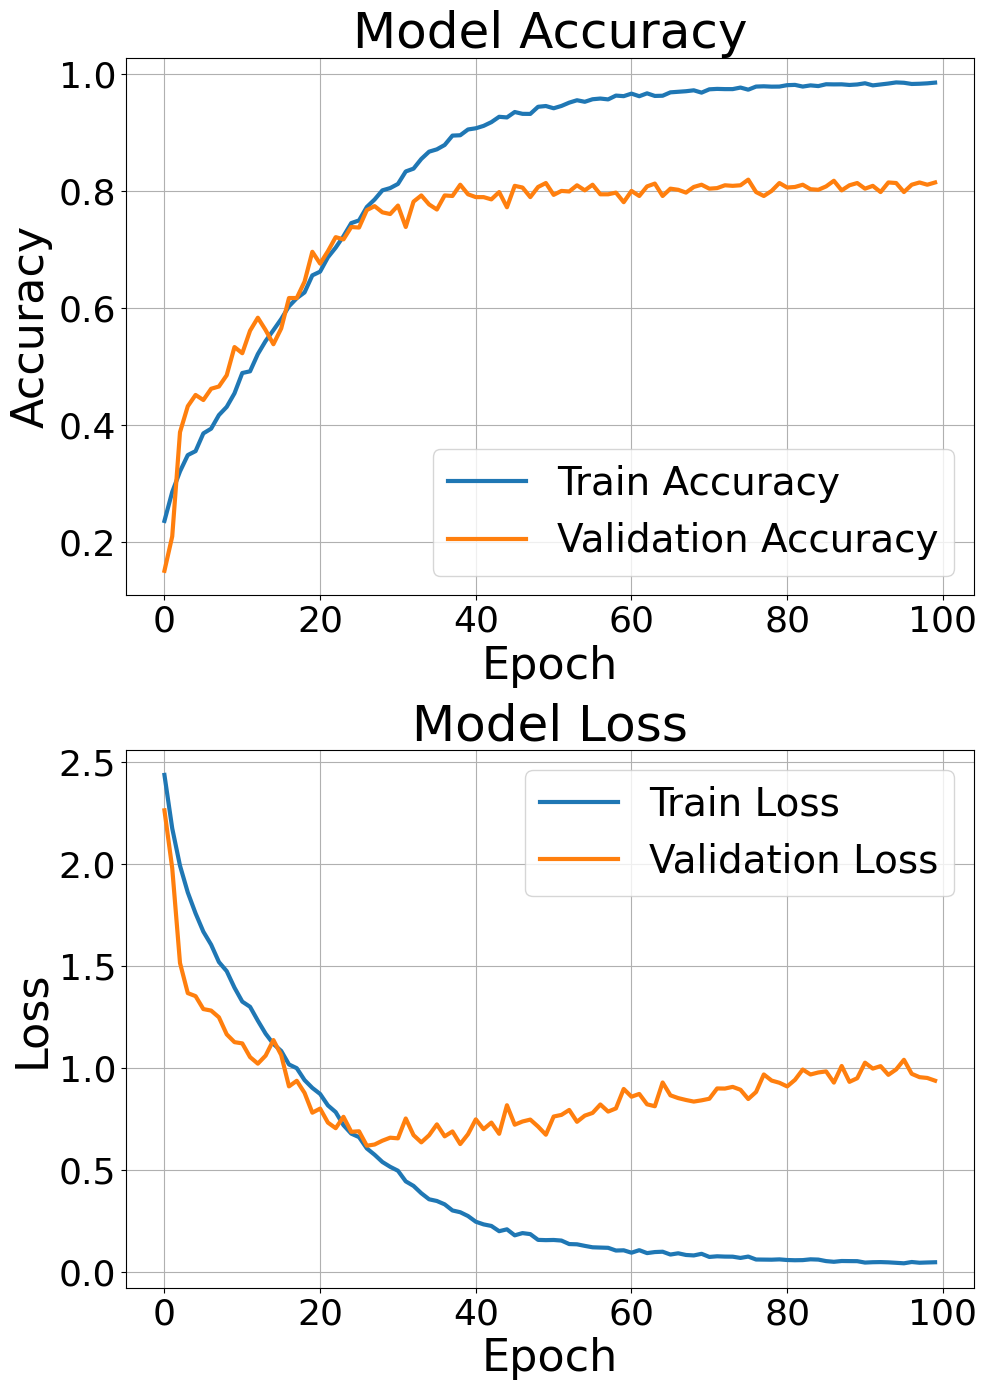

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Taller figure for vertical alignment
plt.figure(figsize=(10,14))

# --- Accuracy Plot (Top) ---
plt.subplot(2, 1, 1)
plt.plot(ModelHistory.history['accuracy'], label='Train Accuracy', linewidth=3)
plt.plot(ModelHistory.history['val_accuracy'], label='Validation Accuracy', linewidth=3)
plt.title('Model Accuracy', fontsize=36)
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Accuracy', fontsize=32)
plt.legend(loc='lower right', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)

# --- Loss Plot (Bottom) ---
plt.subplot(2, 1, 2)
plt.plot(ModelHistory.history['loss'], label='Train Loss', linewidth=3)
plt.plot(ModelHistory.history['val_loss'], label='Validation Loss', linewidth=3)
plt.title('Model Loss', fontsize=36)
plt.xlabel('Epoch', fontsize=32)
plt.ylabel('Loss', fontsize=32)
plt.legend(loc='upper right', fontsize=28)
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)
plt.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 216ms/step

Classification Report:

              precision    recall  f1-score   support

     boredom       0.68      0.71      0.70       175
     confuse       0.73      0.66      0.69       172
       focus       0.82      0.81      0.81       202
  frustrated       0.80      0.82      0.81       169
      sleepy       0.87      0.91      0.89       160
     yawning       0.96      0.97      0.96       161

    accuracy                           0.81      1039
   macro avg       0.81      0.81      0.81      1039
weighted avg       0.81      0.81      0.81      1039



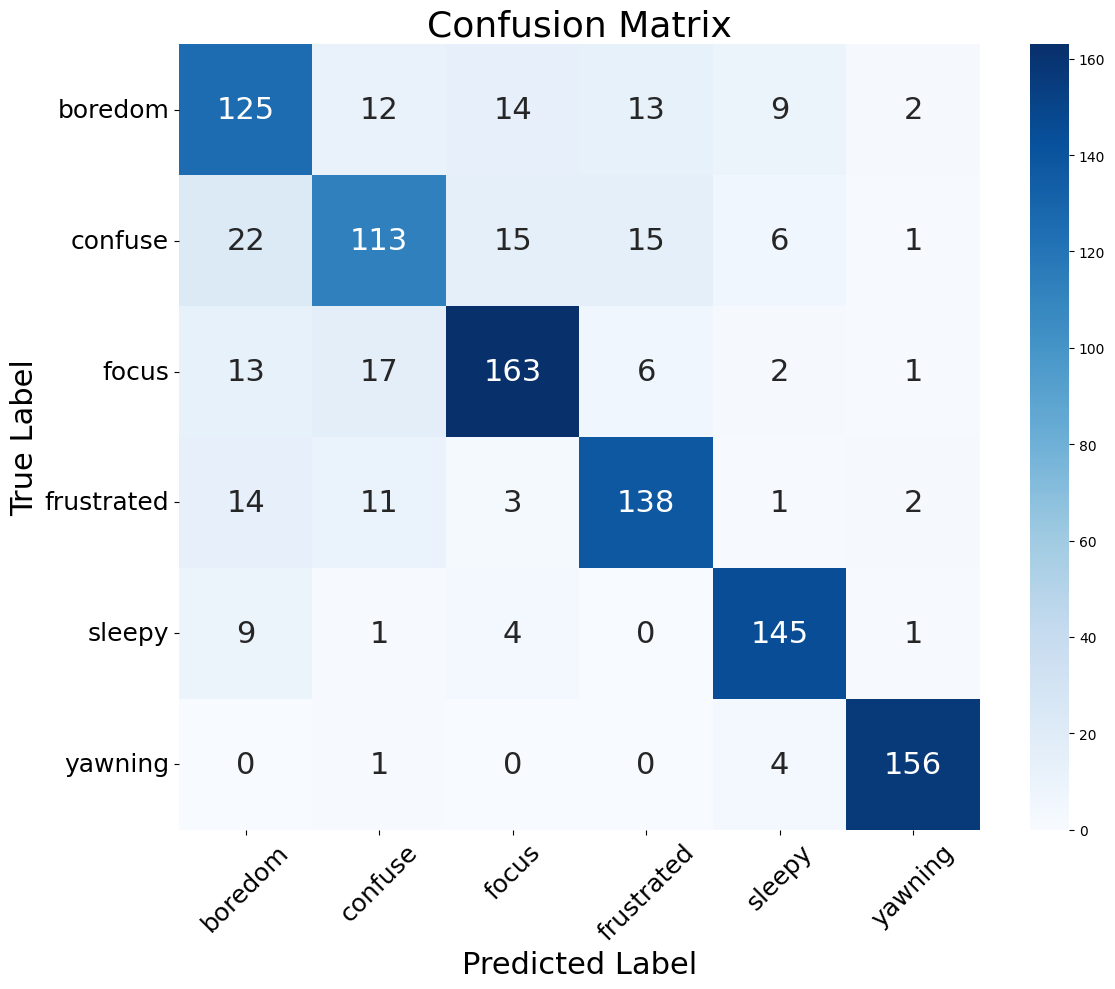

/tmp/ipykernel_35/1665985155.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', n_classes)


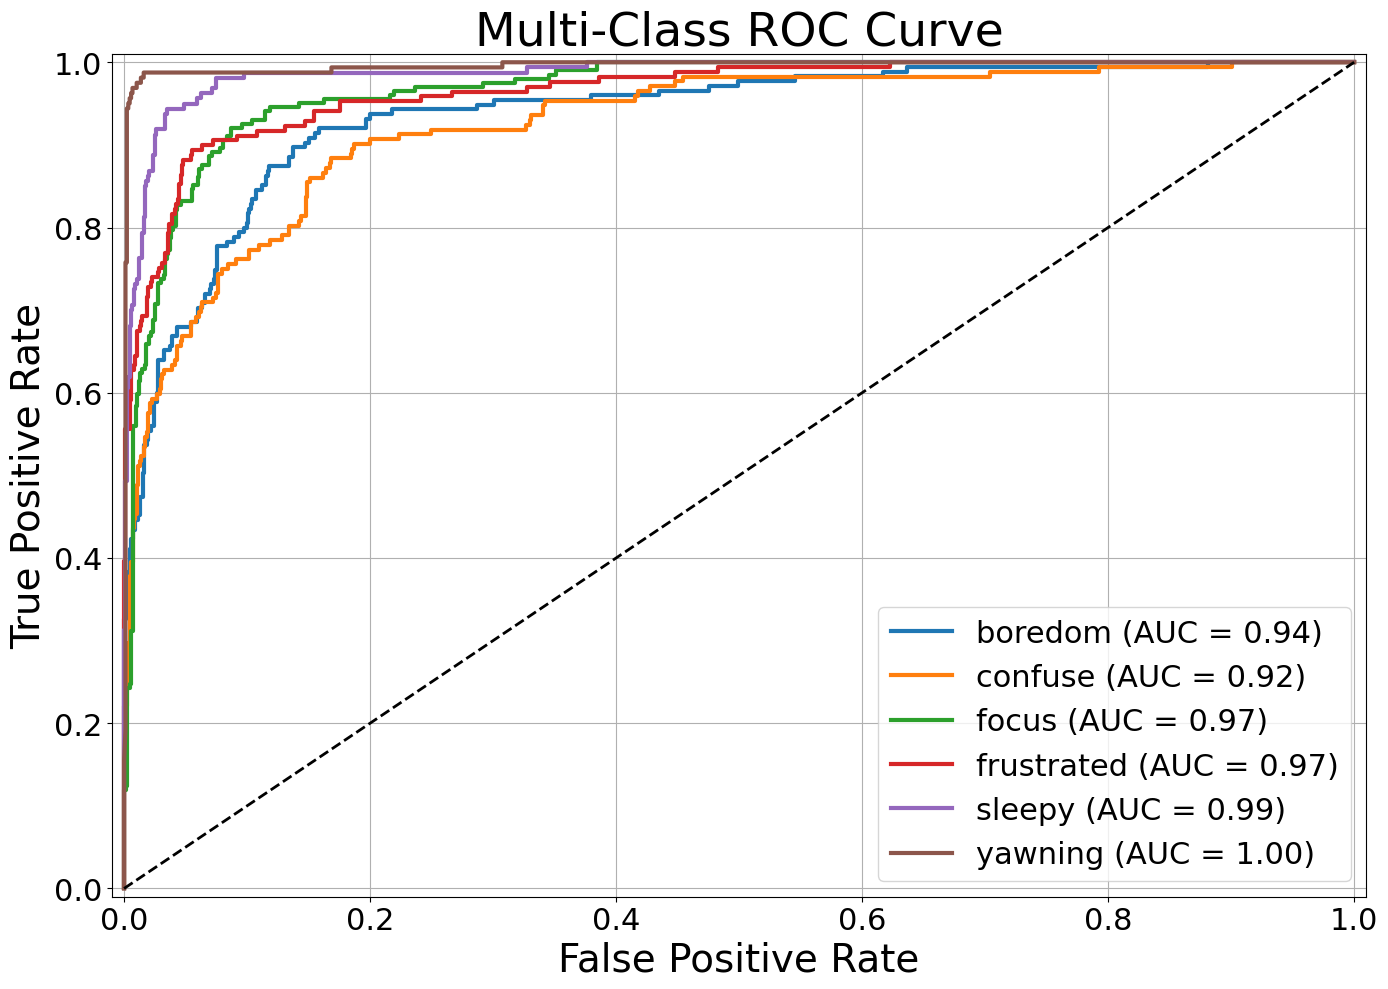

In [24]:


# Step 1: Predict class probabilities and predicted labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)  # <-- This line defines y_true properly

# Step 2: Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=emotionList))

# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotionList, yticklabels=emotionList, annot_kws={"size":22})
plt.title('Confusion Matrix', fontsize=26)
plt.xlabel('Predicted Label', fontsize=22)
plt.ylabel('True Label', fontsize=22)
plt.xticks(fontsize=18, rotation=45)
plt.yticks(fontsize=18, rotation=0)
plt.tight_layout()
plt.show()

# Step 4: Multi-class ROC curve
# Binarize y_true
y_test_bin = label_binarize(y_true, classes=list(range(len(emotionList))))
n_classes = y_test_bin.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(14, 10))
colors = plt.cm.get_cmap('tab10', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=3, label=f'{emotionList[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=28)
plt.ylabel('True Positive Rate', fontsize=28)
plt.title('Multi-Class ROC Curve', fontsize=34)
plt.legend(loc='lower right', fontsize=22)  # ← Increased font size here
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import time
import numpy as np
import subprocess

# --- Timing the prediction ---
start_time = time.time()

# Run prediction
_ = model.predict(X_test)

end_time = time.time()
elapsed_time = end_time - start_time
num_images = X_test.shape[0]

# --- Calculate performance metrics ---
images_per_second = num_images / elapsed_time
avg_prediction_time = elapsed_time / num_images

print(f"\n📊 Total Images: {num_images}")
print(f"⏱️ Total Prediction Time: {elapsed_time:.4f} seconds")
print(f"⚡ Images per Second (Throughput): {images_per_second:.2f}")
print(f"🧠 Average Time per Image: {avg_prediction_time:.4f} seconds")

# --- GPU Power Usage using nvidia-smi ---
print("\n🖥️ Fetching GPU usage details...\n")

try:
    # Use nvidia-smi to get real-time power and GPU utilization
    gpu_stats = subprocess.check_output(
        ["nvidia-smi", "--query-gpu=power.draw,utilization.gpu,memory.used,memory.total", 
         "--format=csv,noheader,nounits"]
    )
    gpu_stats = gpu_stats.decode("utf-8").strip().split('\n')[0]
    power_draw, gpu_util, mem_used, mem_total = map(float, gpu_stats.split(', '))
    
    print(f"🔋 GPU Power Draw: {power_draw} W")
    print(f"🚀 GPU Utilization: {gpu_util}%")
    print(f"📦 GPU Memory Used: {mem_used} MiB / {mem_total} MiB")

except Exception as e:
    print("❌ Unable to fetch GPU details. Error:", str(e))


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

📊 Total Images: 1039
⏱️ Total Prediction Time: 0.7392 seconds
⚡ Images per Second (Throughput): 1405.66
🧠 Average Time per Image: 0.0007 seconds

🖥️ Fetching GPU usage details...

🔋 GPU Power Draw: 47.1 W
🚀 GPU Utilization: 76.0%
📦 GPU Memory Used: 3351.0 MiB / 16384.0 MiB
